In [1]:
%matplotlib inline

In [3]:
import re
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable

import sys
sys.path.append("..")
from tools.lib import load_obj

In [4]:
# define some functions for data loading

def parse_params(group_1, group_2):
    pattern_hparams_1 = r"dataset=(.+)\_model=(.+)"
    pattern_hparams_2 = r"M\_\_bs=(.+)\_model\-lr=(.+)\_epochs=(.+)\_E\_\_l=(.+)\_tau=(.+)\_lambda=(.+)\_interval=(.+)\_seed=(.+)"
    pattern_hparams_2_default = r"M\_\_bs=(.+)\_model\-lr=(.+)\_epochs=(.+)\_seed=(.+)"

    match = re.match(pattern_hparams_1, group_1)
    assert match is not None
    dataset, arch = match.groups()

    match = re.match(pattern_hparams_2, group_2)
    if match:
        _, _, _, _, _, loss_lamb, _, seed = match.groups()
        loss_lamb = float(loss_lamb)
        seed = int(seed)
    else:
        match = re.match(pattern_hparams_2_default, group_2)
        assert match is not None
        loss_lamb = None
        _, _, _, seed = match.groups()
        seed = int(seed)

    return dataset, arch, loss_lamb, seed


def load_mean_std(plot_dataset_model, plot_loss_lamb, data_type):
    dataset, arch = plot_dataset_model
    mean_list = []
    std_list = []
    for loss_lamb in plot_loss_lamb:
        seeds = list(all_data[(dataset, arch)][loss_lamb].keys())
        if data_type in ["HS", "ISY", "test_loss"]:
            raw = [all_data[(dataset, arch)][loss_lamb][seed][data_type] for seed in seeds]
        elif data_type in ["loss_gap"]:
            raw = [all_data[(dataset, arch)][loss_lamb][seed]["test_loss"] -
                   all_data[(dataset, arch)][loss_lamb][seed]["train_loss"] for seed in seeds]
        else:
            raise NotImplementedError
        mean_list.append(np.mean(raw))
        std_list.append(np.std(raw))
    return np.array(mean_list), np.array(std_list)


def get_xmin_xmax(lambs):
    if isinstance(lambs[0], Iterable):
        lambs = [lamb for item in lambs for lamb in item]
    lambs = list(set(lambs))
    if "None" in lambs:
        lambs.remove("None")
    return min(lambs), max(lambs)

In [5]:
# specify the model folder
model_folder = "../saved-models"

In [6]:
all_data = {}
for hparams_1 in os.listdir(model_folder):
    for hparams_2 in os.listdir(osp.join(model_folder, hparams_1)):
        print(f"Loading data from {osp.join(model_folder, hparams_1, hparams_2)}")

        dataset, arch, loss_lamb, seed = parse_params(hparams_1, hparams_2)
        if (dataset, arch) not in all_data:
            all_data[(dataset, arch)] = {}
        loss_lamb = str(loss_lamb) if loss_lamb is None else loss_lamb
        if loss_lamb not in all_data[(dataset, arch)]:
            all_data[(dataset, arch)][loss_lamb] = {}

        info = load_obj(osp.join(model_folder, hparams_1, hparams_2, "evaluate", "info.bin"))
        all_data[(dataset, arch)][loss_lamb][seed] = info

Loading data from ../saved-models/dataset=cifar10_model=resmlp10/M__bs=128_model-lr=0.01_epochs=201_E__l=5_tau=0.001_lambda=-4.5_interval=10_seed=222
Loading data from ../saved-models/dataset=cifar10_model=resmlp10/M__bs=128_model-lr=0.01_epochs=201_E__l=5_tau=0.001_lambda=-4.0_interval=10_seed=444
Loading data from ../saved-models/dataset=cifar10_model=resmlp10/M__bs=128_model-lr=0.01_epochs=201_E__l=5_tau=0.001_lambda=-5.0_interval=10_seed=666
Loading data from ../saved-models/dataset=cifar10_model=resmlp10/M__bs=128_model-lr=0.01_epochs=201_E__l=5_tau=0.001_lambda=-5.0_interval=10_seed=555
Loading data from ../saved-models/dataset=cifar10_model=resmlp10/M__bs=128_model-lr=0.01_epochs=201_E__l=5_tau=0.001_lambda=-4.5_interval=10_seed=666
Loading data from ../saved-models/dataset=cifar10_model=resmlp10/M__bs=128_model-lr=0.01_epochs=201_E__l=5_tau=0.001_lambda=-4.0_interval=10_seed=555
Loading data from ../saved-models/dataset=cifar10_model=resmlp10/M__bs=128_model-lr=0.01_epochs=201_

In [7]:
# specify the data for plot
plot_dataset_models = [("cifar10", "resmlp10")]
plot_loss_lambs = [("None", *np.arange(-5.0, -1.9, 0.5).tolist())]

for dataset_model, loss_lamb in zip(plot_dataset_models, plot_loss_lambs):
    print("->", dataset_model, loss_lamb)

lamb_min, lamb_max = get_xmin_xmax(plot_loss_lambs)
lamb_dummy = lamb_min - 0.5

-> ('cifar10', 'resmlp10') ('None', -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0)


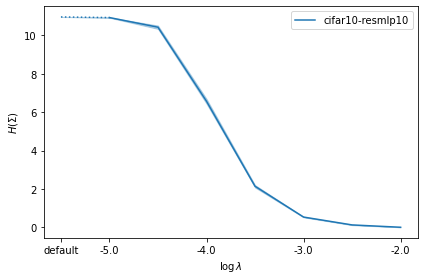

In [8]:
# =========================================== #
#    plot the value of H(\Sigma) of models    #
#  trained using different $\lambda$ values   #
# =========================================== #

plot_means = []
plot_stds = []

for dataset_model, loss_lamb in zip(plot_dataset_models, plot_loss_lambs):
    mean_list, std_list = load_mean_std(
        dataset_model, loss_lamb, data_type="HS"
    )
    plot_means.append(mean_list)
    plot_stds.append(std_list)

plt.figure()

for i in range(len(plot_dataset_models)):
    dataset_model = plot_dataset_models[i]
    loss_lamb = plot_loss_lambs[i][1:]
    mean = plot_means[i][1:]
    std = plot_stds[i][1:]
    color = plt.cm.tab10(i)
    plt.plot(loss_lamb, mean, color=color, label="-".join(dataset_model))
    plt.fill_between(loss_lamb, mean - std, mean + std, color=color, alpha=0.3)

    loss_lamb = [lamb_dummy, plot_loss_lambs[i][1]]
    mean = plot_means[i][:2]
    std = plot_stds[i][:2]
    plt.plot(loss_lamb, mean, color=color, linestyle="dotted")
    plt.fill_between(loss_lamb, mean - std, mean + std, color=color, alpha=0.3)

plt.xlabel(r"$\log\lambda$")
plt.ylabel(r"$H(\Sigma)$")
plt.xticks([lamb_dummy, *np.arange(lamb_min, lamb_max + 0.1, 1.0)],
           ["default", *np.arange(lamb_min, lamb_max + 0.1, 1.0)])
plt.legend()
plt.tight_layout()
plt.show()

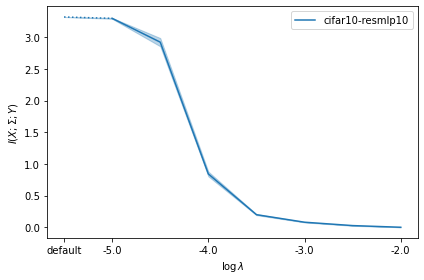

In [9]:
# =========================================== #
#  plot the value of I(X;\Sigma;Y) of models  #
#  trained using different $\lambda$ values   #
# =========================================== #

plot_means = []
plot_stds = []

for dataset_model, loss_lamb in zip(plot_dataset_models, plot_loss_lambs):
    mean_list, std_list = load_mean_std(
        dataset_model, loss_lamb, data_type="ISY"
    )
    plot_means.append(mean_list)
    plot_stds.append(std_list)

plt.figure()

for i in range(len(plot_dataset_models)):
    dataset_model = plot_dataset_models[i]
    loss_lamb = plot_loss_lambs[i][1:]
    mean = plot_means[i][1:]
    std = plot_stds[i][1:]
    color = plt.cm.tab10(i)
    plt.plot(loss_lamb, mean, color=color, label="-".join(dataset_model))
    plt.fill_between(loss_lamb, mean - std, mean + std, color=color, alpha=0.3)

    loss_lamb = [lamb_dummy, plot_loss_lambs[i][1]]
    mean = plot_means[i][:2]
    std = plot_stds[i][:2]
    plt.plot(loss_lamb, mean, color=color, linestyle="dotted")
    plt.fill_between(loss_lamb, mean - std, mean + std, color=color, alpha=0.3)

plt.xlabel(r"$\log\lambda$")
plt.ylabel(r"$I(X;\Sigma;Y)$")
plt.xticks([lamb_dummy, *np.arange(lamb_min, lamb_max + 0.1, 1.0)],
           ["default", *np.arange(lamb_min, lamb_max + 0.1, 1.0)])
plt.legend()
plt.tight_layout()
plt.show()

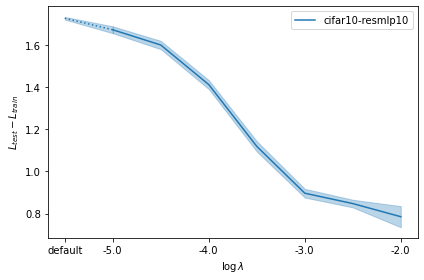

In [10]:
# =========================================== #
#  plot the loss gap (Ltest-Ltrain) of models #
#  trained using different $\lambda$ values   #
# =========================================== #

plot_means = []
plot_stds = []

for dataset_model, loss_lamb in zip(plot_dataset_models, plot_loss_lambs):
    mean_list, std_list = load_mean_std(
        dataset_model, loss_lamb, data_type="loss_gap"
    )
    plot_means.append(mean_list)
    plot_stds.append(std_list)

plt.figure()

for i in range(len(plot_dataset_models)):
    dataset_model = plot_dataset_models[i]
    loss_lamb = plot_loss_lambs[i][1:]
    mean = plot_means[i][1:]
    std = plot_stds[i][1:]
    color = plt.cm.tab10(i)
    plt.plot(loss_lamb, mean, color=color, label="-".join(dataset_model))
    plt.fill_between(loss_lamb, mean - std, mean + std, color=color, alpha=0.3)

    loss_lamb = [lamb_dummy, plot_loss_lambs[i][1]]
    mean = plot_means[i][:2]
    std = plot_stds[i][:2]
    plt.plot(loss_lamb, mean, color=color, linestyle="dotted")
    plt.fill_between(loss_lamb, mean - std, mean + std, color=color, alpha=0.3)

plt.xlabel(r"$\log\lambda$")
plt.ylabel(r"$L_{test}-L_{train}$")
plt.xticks([lamb_dummy, *np.arange(lamb_min, lamb_max + 0.1, 1.0)],
           ["default", *np.arange(lamb_min, lamb_max + 0.1, 1.0)])
plt.legend()
plt.tight_layout()
plt.show()

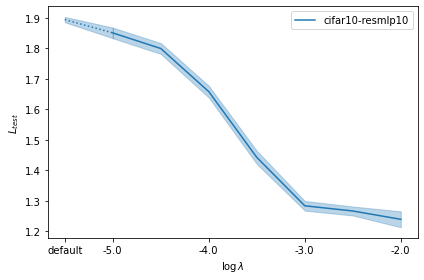

In [11]:
# =========================================== #
#      plot the testing losses of models      #
#  trained using different $\lambda$ values   #
# =========================================== #

plot_means = []
plot_stds = []

for dataset_model, loss_lamb in zip(plot_dataset_models, plot_loss_lambs):
    mean_list, std_list = load_mean_std(
        dataset_model, loss_lamb, data_type="test_loss"
    )
    plot_means.append(mean_list)
    plot_stds.append(std_list)

plt.figure()

for i in range(len(plot_dataset_models)):
    dataset_model = plot_dataset_models[i]
    loss_lamb = plot_loss_lambs[i][1:]
    mean = plot_means[i][1:]
    std = plot_stds[i][1:]
    color = plt.cm.tab10(i)
    plt.plot(loss_lamb, mean, color=color, label="-".join(dataset_model))
    plt.fill_between(loss_lamb, mean - std, mean + std, color=color, alpha=0.3)

    loss_lamb = [lamb_dummy, plot_loss_lambs[i][1]]
    mean = plot_means[i][:2]
    std = plot_stds[i][:2]
    plt.plot(loss_lamb, mean, color=color, linestyle="dotted")
    plt.fill_between(loss_lamb, mean - std, mean + std, color=color, alpha=0.3)

plt.xlabel(r"$\log\lambda$")
plt.ylabel(r"$L_{test}$")
plt.xticks([lamb_dummy, *np.arange(lamb_min, lamb_max + 0.1, 1.0)],
           ["default", *np.arange(lamb_min, lamb_max + 0.1, 1.0)])
plt.legend()
plt.tight_layout()
plt.show()

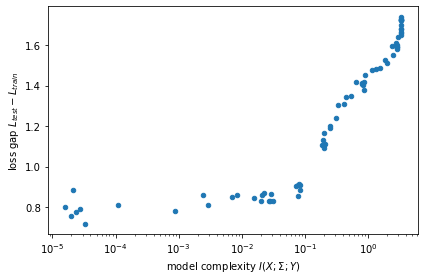

In [12]:
# ===================================== #
#   plot the relationship between the   #
#   model complexity and the loss gap   #
# ===================================== #

dataset = "cifar10"
arch = "resmlp10"

loss_gaps = []
model_compls = []
for loss_lamb in all_data[(dataset, arch)]:
    for seed in all_data[(dataset, arch)][loss_lamb]:
        loss_gap = all_data[(dataset, arch)][loss_lamb][seed]["test_loss"] - \
                   all_data[(dataset, arch)][loss_lamb][seed]["train_loss"]
        model_compl = all_data[(dataset, arch)][loss_lamb][seed]["ISY"]
        loss_gaps.append(loss_gap)
        model_compls.append(model_compl)

plt.figure()
plt.scatter(model_compls, loss_gaps, s=20)
plt.xscale("log")
plt.xlabel(r"model complexity $I(X;\Sigma;Y)$")
plt.ylabel(r"loss gap $L_{test}-L_{train}$")
plt.tight_layout()
plt.show()